In [1]:
import json
import plotnine as p9
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels as sm

import HypTestingHelper as hp

sns.set_style("darkgrid")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


___

# Countries
## Data

In [2]:
# load data from csv
undata = hp.load_undata()

# zoom on Europe and Asia
eudata = undata.loc[undata['Continent'] == 'Europe']
asdata = undata.loc[undata['Continent'] == 'Asia']

# sex ratio
sex_ratio = 'Sex ratio (m per 100 f, 2017)'
eu_sex_ratio = eudata[sex_ratio]
as_sex_ratio = asdata[sex_ratio]

# gdp
as_gdp = asdata.loc[asdata['Region'].isin(['SouthernAsia', 'WesternAsia', 'EasternAsia'])]
eu_gdp = eudata.loc[eudata['Population in thousands (2017)'] > 200]


## T-tests

+ One-way: Check if mean is equal to a given value.
+ Two-ways: check if two means are equal.


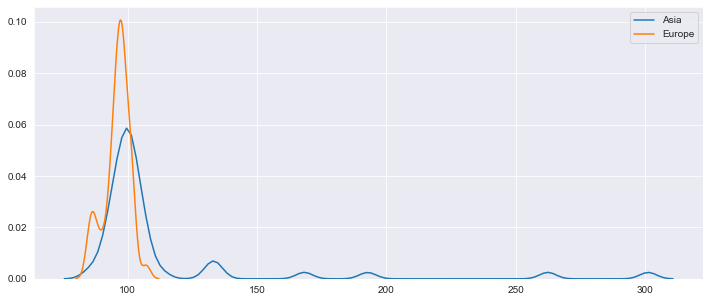

In [3]:
# Sex Ratio - Europe vs Asia
fig, ax = plt.subplots(figsize = (12, 5))
_ = sns.kdeplot(as_sex_ratio, ax=ax, label='Asia')
_ = sns.kdeplot(eu_sex_ratio, ax=ax, label='Europe')


In [4]:
# Create two arrays
eu_sex_ratio = eudata[sex_ratio]
as_sex_ratio = asdata[sex_ratio]


In [5]:
# means
print('EU: {:0.0f} - Asia: {:0.0f}'.format(eu_sex_ratio.mean(), as_sex_ratio.mean()))

# one-sample t-test (Europe)
t_result= stats.ttest_1samp(eu_sex_ratio, 100)
print(t_result)

# two-sample t-test
t_result= stats.ttest_ind(eu_sex_ratio, as_sex_ratio)
print(t_result)

# Wilcoxon rank-sum test (less sensitive to outliers)
wilc = stats.ranksums(eu_sex_ratio, as_sex_ratio)
print(wilc)


EU: 96 - Asia: 112
Ttest_1sampResult(statistic=-5.586380553192841, pvalue=1.2013451466088876e-06)
Ttest_indResult(statistic=-2.7258981706384486, pvalue=0.0076359525385938706)
RanksumsResult(statistic=-3.847431205101039, pvalue=0.00011936277899468487)


### T-tests - Blocked sampling

Sometimes, a variable distribution depends on more than one factor. We can account for these confounding variables by doing blocked sampling: making sure we sample equally among different groups.


## Correlation

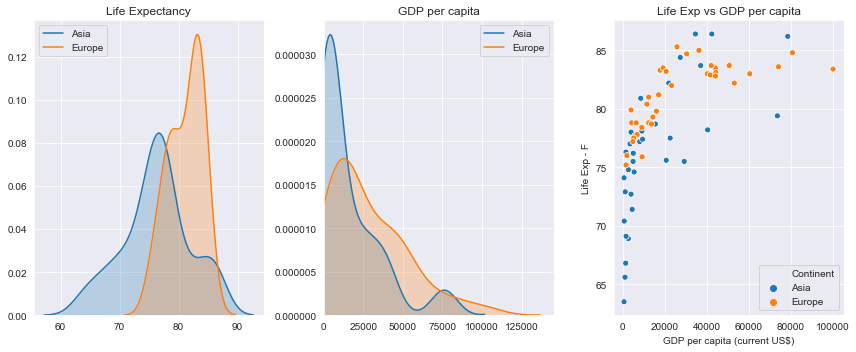

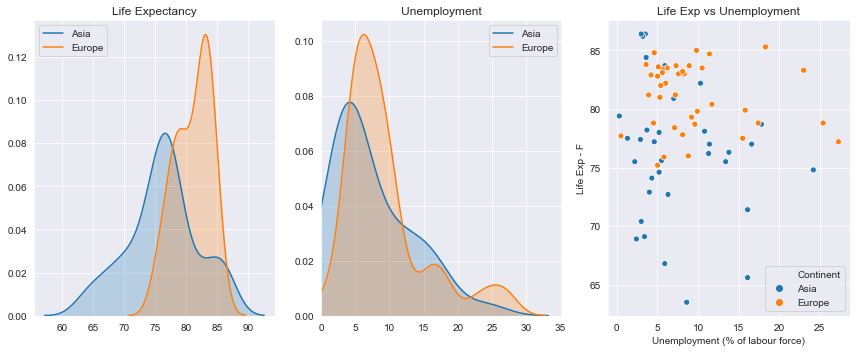

In [6]:
# Life Exp vs GDP vs Unemployment
hp.life_exp_plot(as_gdp, eu_gdp, 'GDP per capita', ['Asia', 'Europe'])
hp.life_exp_plot(as_gdp, eu_gdp, 'Unemployment', ['Asia', 'Europe'])


___

# Olympic Athletes
## Data


In [9]:
# load data from csv
olymp = hp.load_olymp()

# usa
olymp_usa = olymp.loc[olymp['Team'] == 'United States']

# zoom on weight / height
olymp_wt = olymp.loc[~(olymp['Weight'].isna())]
olymp_ht = olymp.loc[~(olymp['Height'].isna())]

# athletics
olymp_wt_mathl = olymp_wt.loc[
    (olymp_wt['Sport'] == 'Athletics') & 
    (olymp_wt['Sex'] == 'M')
]

# 100m
olymp_wt_mmedals_100m = olymp_wt.loc[
    (olymp_wt['ShortEvent'] == '100m') &
    (olymp_wt['Sex'] == 'M') &
    (olymp_wt['MedalTF'] == True)
]

# 100m vs 10k
olymp_wt_100m_10k = olymp_wt.loc[
    olymp_wt['ShortEvent'].isin(['100m', '10k'])
]

# all sports / sex
olymp_wt_usa = olymp_wt.loc[olymp_wt['Team'] == 'United States']
olymp_wt_aus_eth = olymp_wt.loc[olymp_wt['Team'].isin(['Australia', 'Ethiopia'])]
olymp_wt_chi_usa = olymp_wt.loc[olymp_wt['Team'].isin(['China', 'United States'])]

# male athletics
olymp_wt_mathl_chi = olymp_wt_mathl.loc[olymp_wt_mathl['Team'] == 'China']
olymp_wt_mathl_fra = olymp_wt_mathl.loc[olymp_wt_mathl['Team'] == 'France']
olymp_wt_mathl_usa = olymp_wt_mathl.loc[olymp_wt_mathl['Team'] == 'United States']
olymp_wt_mathl_chi_fra_usa = pd.concat((olymp_wt_mathl_chi, olymp_wt_mathl_fra, olymp_wt_mathl_usa))

# specific weight
olymp_wt_usa_m = olymp_wt.loc[
    (olymp_wt['Team'] == 'United States') & 
    (olymp_wt['Sex'] == 'M')
]

# specific ht for usa
olymp_ht_usa_years = olymp_ht.loc[
    (olymp_ht['Team'] == 'United States') & 
    (olymp_ht['Sex'] == 'M') &
    (olymp_ht['Year'].isin([1924, 1952, 2016]))
]

olymp_ht_usa_events = olymp_ht.loc[
    (olymp_ht['Team'] == 'United States') & 
    (olymp_ht['Sex'] == 'M') &
    (olymp_ht['Event'].isin(["Athletics Men's Marathon", "Athletics Men's 100 metres", "Athletics Men's High Jump"]))
]


## Correlation

The Sidak correction can be used in independent tests (less conservative than Bonferroni).

In [10]:
# events
athl_100m = olymp_ht_usa_events.loc[olymp_ht_usa_events['Event'] == "Athletics Men's 100 metres"]
athl_marathon = olymp_ht_usa_events.loc[olymp_ht_usa_events['Event'] == "Athletics Men's Marathon"]
athl_highjump = olymp_ht_usa_events.loc[olymp_ht_usa_events['Event'] == "Athletics Men's High Jump"]

# Perform Pearson correlations
pearson_100m = stats.pearsonr(athl_100m['Year'], athl_100m['Height'])
pearson_marathon = stats.pearsonr(athl_marathon['Year'], athl_marathon['Height'])
pearson_highjump = stats.pearsonr(athl_highjump['Year'], athl_highjump['Height'])

# Create array of p-values
r_array = [pearson_100m[0], pearson_marathon[0], pearson_highjump[0]]
pvals_array = [pearson_100m[1], pearson_marathon[1], pearson_highjump[1]]
print(r_array)
print(pvals_array)

# Perform Sidak correction
adjustedvalues=  sm.stats.multitest.multipletests(pvals_array, method= 'sidak')

# returns can_reject, corrected pvalues & corrected alpha (sidak then bonferroni)
print(adjustedvalues)


[0.253041384289087, 0.4141490659399597, 0.4943063727075835]
[0.009912634135617764, 2.031701704799689e-05, 9.84838426935871e-07]
(array([ True,  True,  True]), array([2.94440955e-02, 6.09498128e-05, 2.95451237e-06]), 0.016952427508441503, 0.016666666666666666)


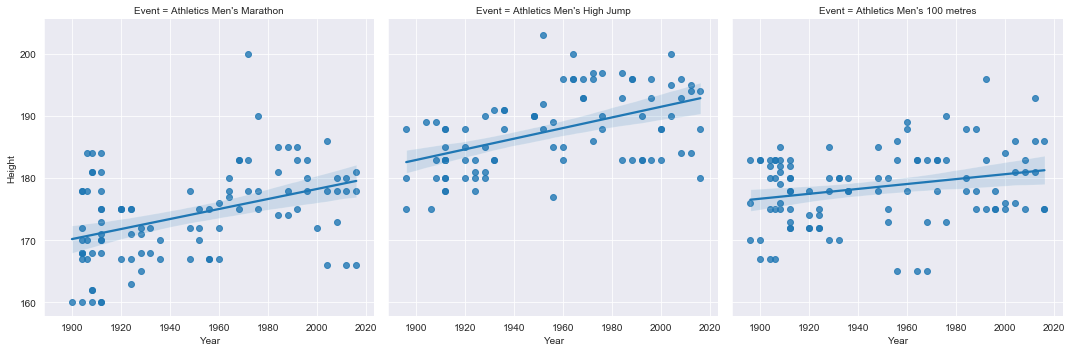

In [11]:
_ = sns.lmplot(x="Year", y="Height", col="Event", data=olymp_ht_usa_events)


### Chi-Squared

+ One-way: test if categories are uniformally distributed.
+ Two-way / Fischer exact test: test if categories of two variables are dependent.

In [12]:
# sex ratio
sexratio = olymp_usa['Sex'].value_counts()
print(sexratio)

# One-way Chi-square test
chi= stats.chisquare(sexratio)
print(chi)


M    3240
F    1584
Name: Sex, dtype: int64
Power_divergenceResult(statistic=568.4776119402985, pvalue=1.2035877899749622e-125)


In [13]:
# Create a table of cross-tabulations
table = pd.crosstab(olymp_usa['MedalTF'], olymp_usa['Sport'])
print(table)

# Perform the Fisher exact test
chi = stats.fisher_exact(table, alternative='two-sided')

# Results (large effect size)
print('p-value: {:0.5f} - Odds ratio between groups: {:0.1f}'.format(chi[1], chi[0]))


Sport    Athletics  Swimming
MedalTF                     
False         2131       556
True          1071      1066
p-value: 0.00000 - Odds ratio between groups: 3.8


### T-tests - Effect Size

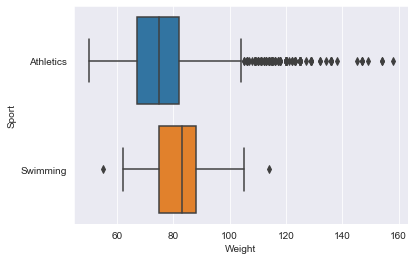

In [14]:
_ = sns.boxplot(y='Sport', x='Weight', data=olymp_wt_usa_m)


In [15]:
# swimmers vs athletes
samp1 = olymp_wt_usa_m.loc[olymp_wt_usa_m['Sport'] == 'Swimming', 'Weight']
samp2 = olymp_wt_usa_m.loc[olymp_wt_usa_m['Sport'] == 'Athletics', 'Weight']

# initialize test
power_test = hp.PowerTest(samp1, samp2, alpha=0.05, power=0.8)

# sample sizes to detect a medium effect size
power_test.get_sample_size(effect_size=0.4)

# effect size that can be detected with the full dataset
power_test.get_effect_size(samp1_size=len(samp1))

# actual effect size for the two samples
power_test.get_cohend()


min sample size to detect effect size = 0.4: samp1: 65 - samp2: 201
   min effect size of full dataset: 0.12239
actual effect size of full dataset: 0.42145


In [16]:
# sample size greatly impacts the p-value:
power_test.rnd_sample_ttest(seed=1007, n=1000)
power_test.rnd_sample_ttest(seed=1007, n=200)
power_test.rnd_sample_ttest(seed=1007, n=50)


n=1000: pvalue = 0.00000 / power = 1.00
n= 200: pvalue = 0.04522 / power = 0.74
n=  50: pvalue = 0.68153 / power = 0.16


### T-tests - Bonferronni correction

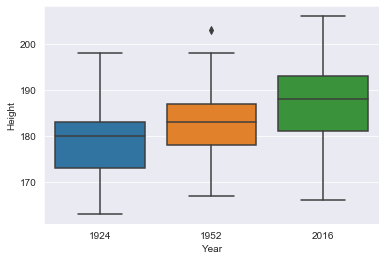

In [17]:
_ = sns.boxplot(x='Year', y='Height', data=olymp_ht_usa_years)


In [18]:
# Heights
ht_1924 = olymp_ht_usa_years.loc[olymp_ht_usa_years['Year'] == 1924, 'Height']
ht_1952 = olymp_ht_usa_years.loc[olymp_ht_usa_years['Year'] == 1952, 'Height']
ht_2016 = olymp_ht_usa_years.loc[olymp_ht_usa_years['Year'] == 2016, 'Height']

# Perform three two-sample t-tests 
t_result_1924v2016= stats.ttest_ind(ht_1924, ht_2016)
t_result_1952v2016= stats.ttest_ind(ht_1952, ht_2016)
t_result_1924v1952= stats.ttest_ind(ht_1924, ht_1952)

# Create an array of p-value results
pvals_array = [t_result_1924v2016[1], t_result_1952v2016[1], t_result_1924v1952[1]]
print(pvals_array)

# Perform Bonferroni correction
adjustedvalues = sm.stats.multitest.multipletests(pvals_array, alpha=0.05, method='bonferroni')

# returns can_reject, corrected pvalues & corrected alpha (sidak then bonferroni)
print(adjustedvalues)


[2.0995273280295586e-16, 4.484419167217926e-05, 0.00013562429334889784]
(array([ True,  True,  True]), array([6.29858198e-16, 1.34532575e-04, 4.06872880e-04]), 0.016952427508441503, 0.016666666666666666)


___
## Athletes
### Data

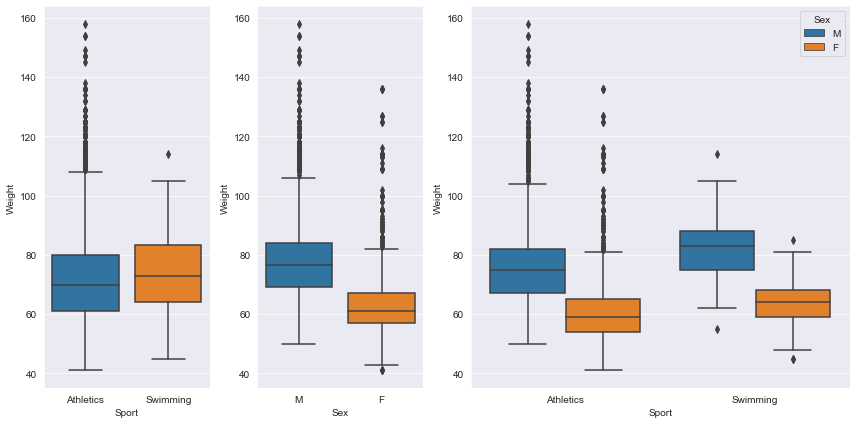

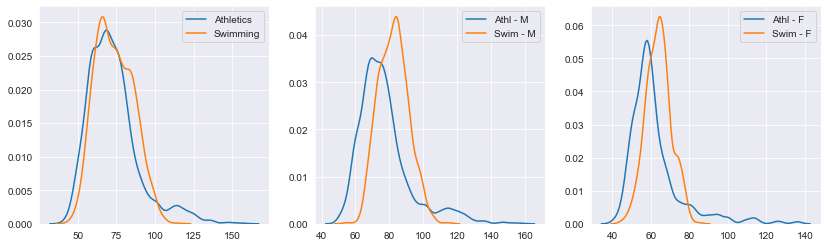

In [38]:
hp.boxplot_with_factors(olymp_wt_usa, ['Sport', 'Sex'], 'Weight') # boxplots of weight per sport / sex
hp.kdeplot_wt_sport_sex(olymp_wt_usa) # kdeplots of weight per sport / sex


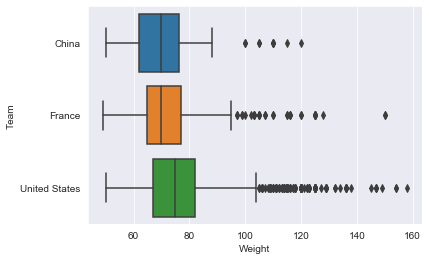

In [22]:
_ = sns.boxplot(y='Team', x='Weight', data=olymp_wt_mathl_chi_fra_usa)


In [23]:
# one-way ANOVA on weight
anova = stats.f_oneway(olymp_wt_mathl_chi['Weight'], olymp_wt_mathl_fra['Weight'], olymp_wt_mathl_usa['Weight'])
print(anova)


F_onewayResult(statistic=36.08494654807696, pvalue=3.216668329007853e-16)


### One-way ANOVA

One-way ANOVA compares means across three samples or more.

In [39]:
# non-blocked t-test
hp.wt_sample_ttest(olymp_wt_usa, n=30, seed=0)
hp.wt_sample_ttest(olymp_wt_usa, n=30, seed=2397)

# blocked t-test (sample men & women separately)
hp.wt_blocked_sample_ttest(olymp_wt_usa, n=30, seed=0)
hp.wt_blocked_sample_ttest(olymp_wt_usa, n=30, seed=2397)
hp.wt_blocked_sample_ttest(olymp_wt_usa, n=30, seed=9000)


Ttest_indResult(statistic=-0.6231916189482111, pvalue=0.5356015934135037)
Ttest_indResult(statistic=-2.1315597041503707, pvalue=0.0372913986545787)
Ttest_indResult(statistic=-1.8292379019217426, pvalue=0.0725059669389294)
Ttest_indResult(statistic=-1.9839342705151362, pvalue=0.052002561389767006)
Ttest_indResult(statistic=-2.9477612234116326, pvalue=0.004605461953501263)


In [230]:
# ANOVA on linear model w/o interaction effect
formula = 'Weight ~ Sex + Sport'
model = sm.api.OLS.from_formula(formula, data=olymp_wt_usa).fit()
anova_table = sm.api.stats.anova_lm(model, typ=2)
print(anova_table)


sum_sq      df            F         PR(>F)
Sex       246992.348590     1.0  1388.613622  1.352459e-263
Sport      14017.813025     1.0    78.809430   9.865718e-19
Residual  763772.677989  4294.0          NaN            NaN


In [231]:
# ANOVA on linear model with interaction effect
formula = 'Weight ~ Sex + Sport + Sex:Sport'
model = sm.api.OLS.from_formula(formula, data=olymp_wt_usa).fit()
anova_table = sm.api.stats.anova_lm(model, typ=2)
print(anova_table)


sum_sq      df            F         PR(>F)
Sex        246992.348590     1.0  1392.543690  3.117823e-264
Sport       14017.813025     1.0    79.032477   8.831156e-19
Sex:Sport    2332.903855     1.0    13.152920   2.904059e-04
Residual   761439.774134  4293.0          NaN            NaN


### Two-way ANOVA

Two-way ANOVA measures the impact of several factors.

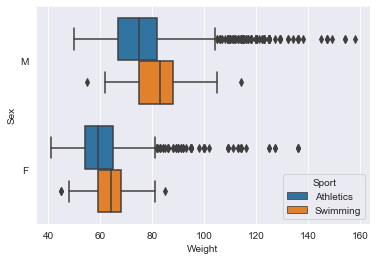

In [229]:
_ = sns.boxplot(y='Sex', x='Weight', hue='Sport', data=olymp_wt_usa)


___
## Potatoes

The paired test is more sensitive than the independent test and can pick up a difference that the independent test can't detect. This is because the difference within the samples each year (individual field effect) is quite large in comparison to the difference between the two years (effect of treatment). Paired tests are useful when a large variability exists.

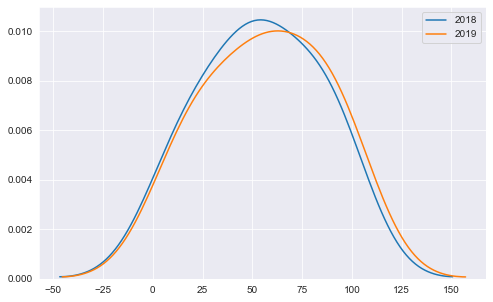

In [225]:
# Yield - 2019 vs 2018
fig, ax = plt.subplots(figsize = (8, 5))
_ = sns.kdeplot(podataframe['Yield2018'], ax=ax, label='2018')
_ = sns.kdeplot(podataframe['Yield2019'], ax=ax, label='2019')



In [226]:
# Shapiro-Wilk shows both distributions are normal
print(stats.shapiro(podataframe.Yield2018))
print(stats.shapiro(podataframe.Yield2019))


(0.9190050959587097, 0.3487319350242615)
(0.9260056614875793, 0.4097716510295868)


In [33]:
podataframe = pd.DataFrame(
    [
        ['A', 60.2, 63.2],
        ['B', 12.0, 15.6],
        ['C', 13.8, 14.8],
        ['D', 91.8, 96.7],
        ['E', 50.0, 53.0],
        ['F', 45.0, 47.0],
        ['G', 32.0, 31.3],
        ['H', 87.5, 89.8],
        ['I', 60.1, 67.8],
        ['J', 88.0, 90.0]
    ], columns = ['Field', 'Yield2018', 'Yield2019']
)

podataframe['Variations'] = podataframe['Yield2019'] - podataframe['Yield2018']


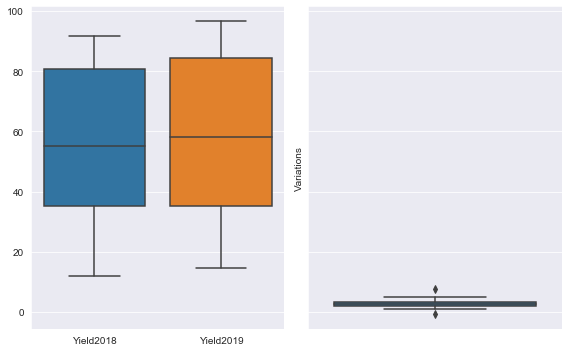

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (8, 5), tight_layout=True, sharey=True)
_ = sns.boxplot(data=podataframe[['Yield2018', 'Yield2019']], ax=ax1)
_ = sns.boxplot(y='Variations', data=podataframe, ax=ax2)


In [227]:
#independent t-test
ttestind = stats.ttest_ind(podataframe.Yield2018, podataframe.Yield2019)
print(ttestind)

# paired t-test
ttestpair = stats.ttest_rel(podataframe.Yield2018, podataframe.Yield2019)
print(ttestpair)

# Wilcoxon Signed-Rank test (pvalue is bigger than the paired t-test)
wilcsr = stats.wilcoxon(podataframe.Yield2018, podataframe.Yield2019)
print(wilcsr)


Ttest_indResult(statistic=-0.21660326792826629, pvalue=0.8309534738562026)
Ttest_relResult(statistic=-4.024223770175694, pvalue=0.0029989293692974325)
WilcoxonResult(statistic=1.0, pvalue=0.00683774356850919)
